<a href="https://colab.research.google.com/github/souhityac/LSTM-based-NSE-Stock-Predictions/blob/main/LSTM_NSE_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Installing investpy

!pip install investpy

In [2]:
# Data Collection 
# HDFC Bank data - January,2016 to Oct,2020
# Timeframe - Daily

import investpy

df = investpy.get_stock_historical_data(stock='HDBK',
                                        country='India',
                                        from_date='01/01/2016',
                                        to_date='08/10/2020')


In [3]:
# Size of dataset 

df.shape

(1180, 6)

In [4]:
# Creating a dataframe of the downloaded data

import pandas as pd

df = pd.DataFrame(df)

In [30]:
df

,Open,High,Low,Close,Volume
Date,,,,,
2016-01-01,540.00,543.91,536.88,543.17,1597538
2016-01-04,540.80,540.80,532.86,534.06,2593768
2016-01-05,533.91,536.21,529.50,530.02,1580436
2016-01-06,527.15,537.18,527.15,532.36,2082768
2016-01-07,528.87,531.27,523.68,526.93,3027714
...,...,...,...,...,...
2020-10-01,1090.10,1110.00,1090.10,1106.95,10601566
2020-10-05,1112.00,1132.00,1111.00,1114.35,8470109
2020-10-06,1135.05,1148.00,1126.20,1144.10,9685997


In [5]:
# Dropping currency and volume columns 

df = df.drop(['Currency'],axis=1)

In [ ]:
df

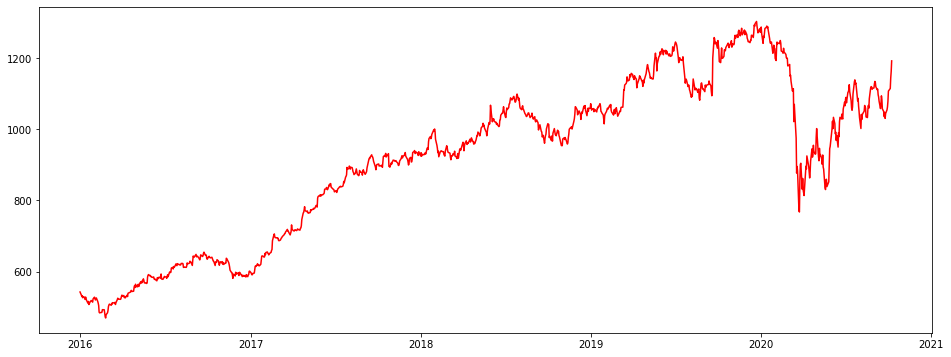

In [24]:
# Plotting the data

import matplotlib.pyplot as plt

plt.figure(1,figsize=(16,6))
_ = plt.plot(df.Close, color='red')

In [7]:
# Dropping null values

df.dropna(inplace=True)

# Feature Set of OHLC

X = df.values

In [8]:
# Preprocessing the data 

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1)).fit(X)
X_scaled = scaler.transform(X)

In [10]:
# Creating the labels
# Setting 'Close' as the label to predict 

Y = [x[3] for x in X_scaled]

In [66]:
# Train-Test Split 

split= int(len(X_scaled)*0.70)
x_train = X_scaled[:split]
x_test = X_scaled[split: len(X_scaled)]
y_train = Y[:split]
y_test = Y[split: len(Y)]


In [67]:
# Creating window data: input for time-series model
# Using 2 trading weeks of data as input to predict the next timestep

timestep = 10
xtrain,ytrain,xtest,ytest = [],[],[],[]

for i in range(timestep, len(x_train)):
  xtrain.append(x_train[i-timestep:i, :x_train.shape[1]])
  ytrain.append(y_train[i])

for i in range(timestep, len(x_test)):
  xtest.append(x_test[i-timestep:i, :x_test.shape[1]])
  ytest.append(y_test[i])

In [69]:
# Converting window data into arrays to pass as input to the model

import numpy as np 
xtrain,ytrain = (np.array(xtrain),np.array(ytrain))
xtrain = np.reshape(xtrain, (xtrain.shape[0],xtrain.shape[1],xtrain.shape[2]))

xtest,ytest = (np.array(xtest),np.array(ytest))
xtest = np.reshape(xtest, (xtest.shape[0],xtest.shape[1],xtest.shape[2]))

In [57]:
# Batch size calculator

import math
math.gcd(xtrain.shape[0],xtest.shape[0])

8

In [58]:
import time
import warnings
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import matplotlib.pyplot as plt

In [ ]:
# LSTM Model with 32-32-16 architecture

model = Sequential()

model.add(LSTM(units=32,batch_size=8,input_shape = (10,5),stateful=True,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(units=32,stateful=True,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(units=16,stateful=True,return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1,activation='linear'))
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mean_absolute_error'])

model.summary()

In [ ]:
# Training the model
# Loss metric: Mean Squared Error

model.fit(xtrain,ytrain,epochs=100,validation_data=(xtest,ytest), batch_size=8,verbose=1)

In [64]:
# Testing the model 

testpredict = model.predict(xtest, batch_size=8)

Text(0, 0.5, 'Normalised Close')

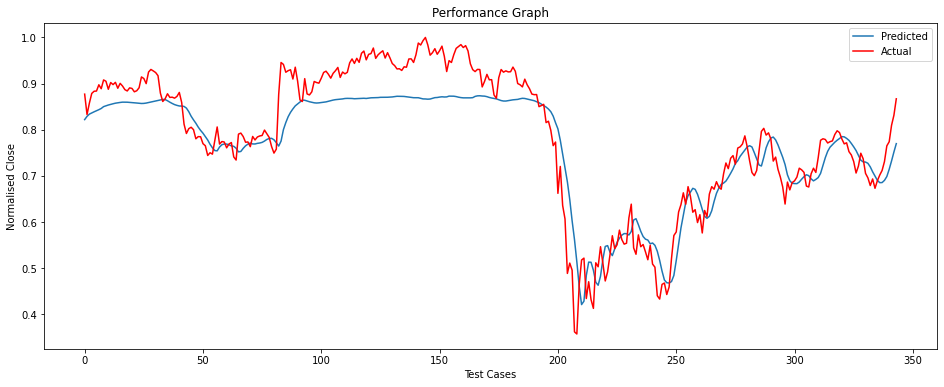

In [65]:
# Plotting the results

plt.figure(2,figsize=(16,6))
_ = plt.plot(testpredict,label='Predicted')
t = plt.plot(ytest,label='Actual',color='red')
plt.legend()
plt.title('Performance Graph')
plt.xlabel('Test Cases')
plt.ylabel('Normalised Close')